# import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
import sklearn.metrics as sklm
import xgboost as xgb
from sklearn.decomposition import PCA

import create_model as cm

# Read .csv files

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test_org = df_test.copy()

print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


# Drop column: Id

In [3]:
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


# Drop Outliers

### According to GrLivArea

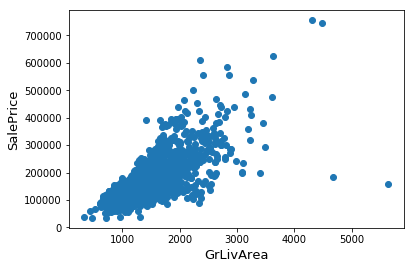

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

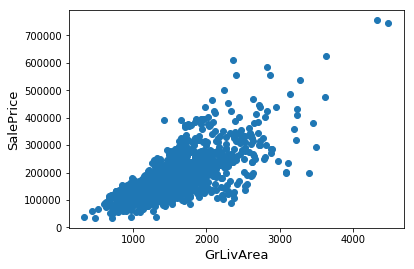

In [5]:
#Deleting outliers
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### According to Tukey's Test (numerical features)

'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'

In [6]:
def Tukey_test(df, tar_list, k=3):
    df_new = pd.DataFrame()
    for col in tar_list:
        q1 = np.percentile(df[col].values, 25)
        q3 = np.percentile(df[col].values, 75)
        IQR = q3 - q1
        max_range = q3 + k*IQR
        min_range = q1 - k*IQR
        df_new[col] = df[col].clip(min_range, max_range)
    return df_new

In [7]:
num_cols = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
df_train[num_cols] = Tukey_test(df_train, num_cols)
df_train.shape

C:\Users\Student\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


(1458, 80)

# Check duplicate values of every columns

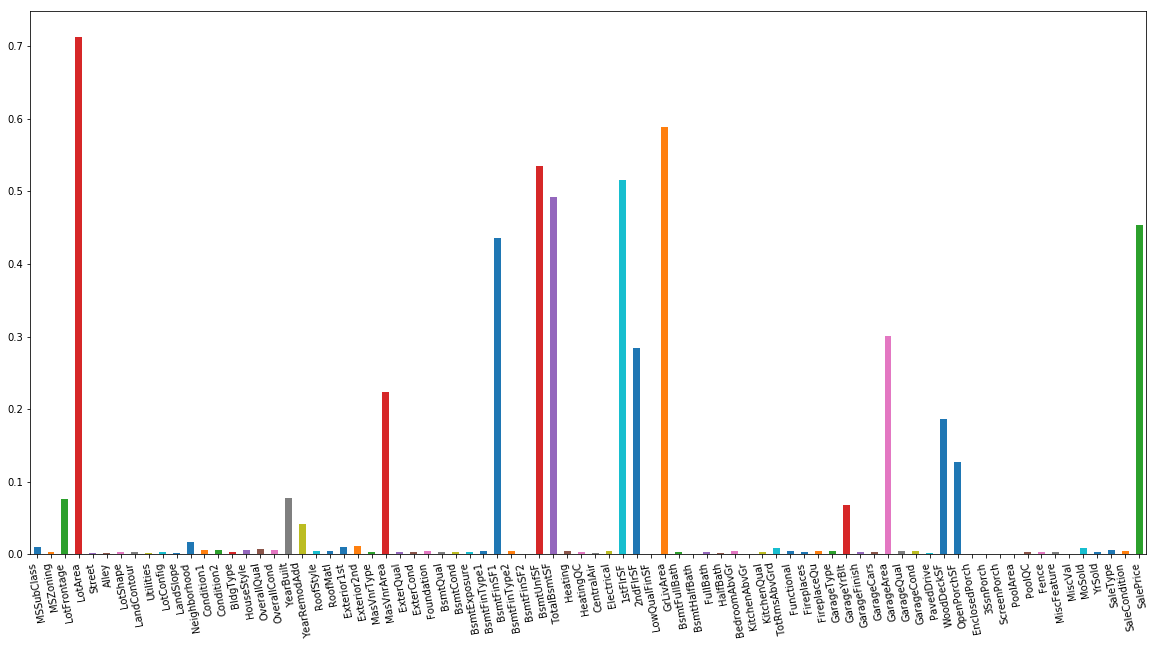

In [8]:
plt.figure(figsize=(20,10))
(df_train.apply(lambda x:x.unique().shape[0], axis=0)/df_train.shape[0]).plot(kind='bar', rot=100);

# Transforming numerical features that are actually categorical

In [9]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)

df_train['MoSold'] = df_train['MoSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)

# df_train['YrSold'] = df_train['YrSold'].astype(str)
# df_test['YrSold'] = df_test['YrSold'].astype(str)

# Handling missing data

### Check numbers of columns which have missing data

In [10]:
df_train.isnull().any().sum()

19

In [11]:
df_test.isnull().any().sum()

33

### Check counts of missing data

In [12]:
train_null = df_train.isnull().sum(axis=0)
train_null = train_null[train_null != 0]
train_null

LotFrontage      259
Alley           1367
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1452
Fence           1177
MiscFeature     1404
dtype: int64

In [13]:
test_null = df_test.isnull().sum(axis=0)
test_null = test_null[test_null != 0]
test_null

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

### Slice SalePrice of training data as y_train, and concatenate train and test data.

In [14]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

df_train_y = df_train.SalePrice
train_y = df_train.SalePrice.values
print('train_y.shape:', train_y.shape)

# df_train['training_set'] = True
# df_test['training_set'] = False
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

train_y.shape: (1458,)


C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  # Remove the CWD from sys.path while we load stuff.


(2917, 79)

### Calculate counts of missing data and percentage

In [15]:
total_missing = all_data.isnull().sum().sort_values(ascending=False)
percentage = ((all_data.isnull().sum()/all_data.isnull().count())*100).sort_values(ascending=False)

missing = pd.concat([total_missing, percentage],axis=1,keys=['Total','Percentage'])
missing.head(20)

,Total,Percentage
PoolQC,2908,99.691464
MiscFeature,2812,96.400411
Alley,2719,93.212204
Fence,2346,80.425094
FireplaceQu,1420,48.680151
LotFrontage,486,16.660953
GarageFinish,159,5.450806
GarageQual,159,5.450806
GarageYrBlt,159,5.450806
GarageCond,159,5.450806


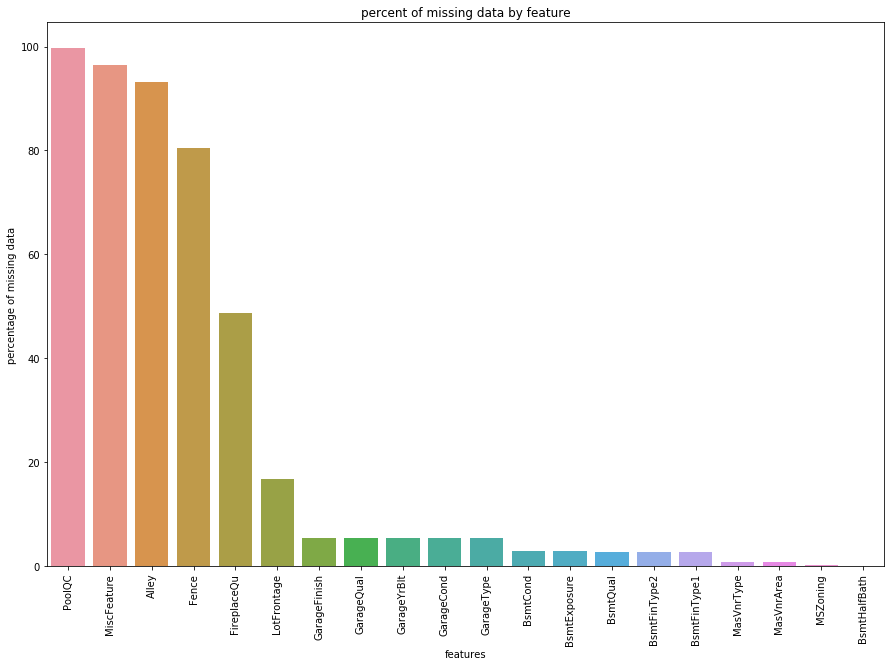

In [16]:
# 設定圖框大小
plt.subplots(figsize=(15,10))

# X軸標題旋轉90度
plt.xticks(rotation='90')

#劃出barplot
sns.barplot(x=total_missing.index[:20], y=percentage[:20])

#設定x, y標題
plt.xlabel('features')
plt.ylabel('percentage of missing data')

#設定title
plt.title('percent of missing data by feature')

plt.show()

### Drop columns if missing data more than 40%

In [17]:
col_drop = missing[missing['Percentage']>=40].index
for col in col_drop:
    print('drop column:', str(col))

all_data = all_data.drop(col_drop, axis=1)
all_data.shape

drop column: PoolQC
drop column: MiscFeature
drop column: Alley
drop column: Fence
drop column: FireplaceQu


(2917, 74)

### Filling in missing data

MSZoning:
    
Fill in the most common value 'RL'

In [18]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

LotFrontage:

Median LotFrontage of the neighborhood

In [19]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

Utilities:
    
remove this column(almost same category)

In [20]:
all_data = all_data.drop(['Utilities'], axis=1)

Exterior1st, Exterior2nd:

Fill in the most common value

In [21]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

MasVnrArea, MasVnrType:
    
MasVnrArea fill in 0, and MasVnrType fill in 'None' (no masonry veneer)

In [22]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna('None')
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

Electrical:

Fill in the most common value 'SBrkr'

In [23]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath:

fill in 0 (Because there is no basement!)

In [24]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF'):
    all_data[col] = all_data[col].fillna(0)

# all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)

KitchenQual:
    
Fill in the most common value 'TA'

In [25]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

Functional:
    
Feature description indicates that NA means typical

In [26]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

GarageYrBlt, GarageArea, GarageCars: 
    
fill in 0 (Because there is no garage!)

In [27]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

Fill in 'None'

FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, MasVnrType, MSSubClass 

In [28]:
# fill in 'None'
def fill_categorical(col):
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')
    else:
        print(col, 'not in dataset')

In [29]:
col_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
for col in col_categorical:
    fill_categorical(col)

SaleType:

Fill in the most common value 'WD'

In [30]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

### Check remaining missing value 

In [31]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


In [32]:
all_data.shape

(2917, 73)

# Features Engineering

### Numerical feature selection according to correlation

In [33]:
plt.figure(figsize=(10,10))
corr_matrix = df_train.corr()
filter_corr_feature = corr_matrix.index[abs(corr_matrix['SalePrice'])<0.35]
# sns.heatmap(df_train[filter_corr_feature].corr(), annot=True, cmap='winter');
filter_corr_feature

Index(['OverallCond', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFullBath', 'HalfBath',
       'BedroomAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'YrSold'],
      dtype='object')

<Figure size 720x720 with 0 Axes>

In [34]:
all_data.drop(filter_corr_feature, axis=1, inplace=True)
all_data.shape

(2917, 64)

### Transforming hierarchical categories to numerical features

LotShape, LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, GarageFinish, GarageQual, GarageCond

In [35]:
def fill_ordered_category(series, li):
    category_dict = {}
    li = li[::-1]
    for n in range(len(li)):
        category_dict[li[n]] = n
    series = series.map(category_dict)
    return series

In [36]:
transform_dict = {
'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
'LandSlope': ['Gtl', 'Mod', 'Sev'],
'ExterQual': ['Ex', 'Gd', 'TA', 'Fa'],
'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'None'],
'BsmtCond': ['Gd', 'TA', 'Fa', 'Po', 'None'],
'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'None'],
'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None'],
'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None'],
'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'None'],
'GarageFinish': ['Fin', 'RFn', 'Unf', 'None'],
'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None'],
'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None']
}

for se in transform_dict:
    all_data[se] = fill_ordered_category(all_data[se], transform_dict[se])

all_data.shape

(2917, 64)

### One hot encoding

In [37]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
print(all_data.info())

(2917, 237)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Columns: 237 entries, 1stFlrSF to Street_Pave
dtypes: float64(25), int64(14), uint8(198)
memory usage: 1.4 MB
None


### Get new train and test data

In [38]:
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

print(df_train.shape)
print(df_test.shape)

(1458, 237)
(1459, 237)


In [39]:
df_train_y.shape

(1458,)

In [40]:
df_train = pd.concat((df_train, df_train_y), axis=1)
df_train.shape

(1458, 238)

### Define x and y

In [41]:
x = df_train.iloc[:, :-1].values
y = train_y

### Data standardization

In [42]:
scaler_train = StandardScaler()
scaler_train = scaler_train.fit(x)
x = scaler_train.transform(x)

scaler_test = StandardScaler()
scaler_test = scaler_test.fit(df_test)
test_x = scaler_test.transform(df_test)

### PCA

### Feature selection by Lasso (y is numeric)

In [43]:
from sklearn.linear_model import LassoCV
# lassocv = LassoCV(alphas=[i for i in range(1, 1000)], max_iter=50000, normalize=False)
lassocv = LassoCV(max_iter=50000, normalize=False)
lassocv.fit(x, y)

mask = (lassocv.coef_ != 0)
x = x[:, mask]
x.shape

(1458, 88)

In [44]:
lassocv.alpha_

678.084865670894

In [45]:
test_x = test_x[:, mask]
print(test_x.shape)

(1459, 88)


# Modeling

### Split to train and test

In [46]:
# Split train to 80% for training and 20% for validation
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(1166, 88)
(1166,)
(292, 88)
(292,)


### 1. Linear Regression

In [47]:
def linear_modeling(train_x, train_y):
    linear_regressor = LinearRegression()
    linear_model = linear_regressor.fit(train_x, train_y)
    return linear_model

In [48]:
linear_model = linear_modeling(train_x, train_y)
pred_y = linear_model.predict(val_x)
r2_score(val_y, pred_y)

0.9017816942010743

In [49]:
test_y = linear_model.predict(test_x)

df_result = pd.DataFrame(df_test_org['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('submit/linear_result.csv', index=False)

### 2. Lasso Regression¶

In [50]:
def lasso_moedeling(train_x, train_y):
    lassocv = LassoCV()
    lassocv.fit(train_x, train_y)
    alpha = lassocv.alpha_
    max_iter = lassocv.max_iter
    tol = lassocv.tol
    # create regressor
    lasso_regressor = Lasso(max_iter=max_iter, alpha=alpha, tol=tol)
    # create model
    lasso_model = lasso_regressor.fit(train_x, train_y)
    return lasso_model

In [51]:
lasso_model = lasso_moedeling(train_x, train_y)
pred_y = lasso_model.predict(val_x)
r2_score(val_y, pred_y)

0.8941608502206807

In [52]:
test_y = lasso_model.predict(test_x)

df_result = pd.DataFrame(df_test_org['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('submit/Lasso_result.csv', index=False)

### 3. Ridge Regression

In [53]:
def ridge_modeling(train_x, train_y):
    ridgecv = RidgeCV()
    ridgecv.fit(train_x, train_y)
    alpha = ridgecv.alpha_
    # create regressor
    ridge_regressor = Ridge(max_iter=10000000, alpha=alpha)
    ridge_model = ridge_regressor.fit(train_x, train_y)
    return ridge_model

In [54]:
ridge_model = ridge_modeling(train_x, train_y)
pred_y = ridge_model.predict(val_x)
r2_score(val_y, pred_y)

0.9013951114750484

In [55]:
test_y = ridge_model.predict(test_x)

df_result = pd.DataFrame(df_test_org['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('submit/Ridge_result.csv', index=False)

### 4. Elastic Net Regression

In [56]:
def elastic_modeling(train_x, train_y):
    elasticnetcv = ElasticNetCV()
    elasticnetcv.fit(train_x, train_y)
    tol = elasticnetcv.tol
    l1_ratio = elasticnetcv.l1_ratio
    # create regressor
    elasticnet_regressor = ElasticNet(max_iter=10000000, l1_ratio=l1_ratio, tol=tol)
    # create model
    elasticnet_model = elasticnet_regressor.fit(train_x, train_y)
    return elasticnet_model

In [57]:
elasticnet_model = elastic_modeling(train_x, train_y)
pred_y = elasticnet_model.predict(val_x)
r2_score(val_y, pred_y)

0.8817217741769269

In [58]:
test_y = elasticnet_model.predict(test_x)

df_result = pd.DataFrame(df_test_org['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('submit/Elasticnet_result.csv', index=False)

### 5. Random Forest

In [62]:
def rf_modeling(train_x, train_y):
    rf = RandomForestRegressor()
    param_grid = { 
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
    }
    grid_rf = GridSearchCV(rf, param_grid, n_jobs=-1, cv=5)
    forest_model = grid_rf.fit(train_x, train_y)
    return forest_model

In [63]:
forest_model = rf_modeling(train_x, train_y)
pred_y = forest_model.predict(val_x)

print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(val_y, pred_y))))
r2_score(val_y, pred_y)

Root Mean Square Error = 35737.57478485174


0.7920205366110852

In [ ]:
# forest_model = rf_modeling(x, y)
test_y = forest_model.predict(test_x)

df_result = pd.DataFrame(df_test_org['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('submit/Forest_result.csv', index=False)

### 6. XGBoost

In [59]:
def xgb_modeling(train_x, train_y, val_x, val_y):
    # 將資料存成xgboost要求的型態
    data_val  = xgb.DMatrix(val_x, label=val_y)
    data_train = xgb.DMatrix(train_x, label=train_y)
    
    #給予模型參數，告知演算法該如何訓練模型
    param = {}
    param['objective'] = 'reg:linear' # 做線性回歸
    param['tree_method'] = 'hist'
    param['silent']=1
    param['max_depth']=5
    eval_list  = [(data_train,'train'),(data_val,'validation')]
    num_round = 20
    eval_history={}

    # 訓練模型
    xgb_model = xgb.train(param, data_train, num_round, eval_list, 
                          evals_result=eval_history, verbose_eval=False)
    
    #檢視訓練情形
    rmse_train=eval_history['train']['rmse']
    rmse_validation=eval_history['validation']['rmse']
    plt.plot(rmse_train,ms=10,marker='.',label='train_eval')
    plt.plot(rmse_validation,ms=10,marker='v',label='validation_eval')
    plt.legend()
    plt.show()
    
    # 檢視最後rms error
    print("RMSE:", xgb_model.eval(data_val))
    
    #以R^2評估回歸結果(validation)
    pred_y = xgb_model.predict(data_val)
    print("r-square for validation data is", r2_score(val_y, pred_y))
    
    #以R^2評估回歸結果(train)
    train_pred_y = xgb_model.predict(data_train)
    print("r-square for train data is", r2_score(train_y, train_pred_y))
    
    return xgb_model
    

[20:32:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


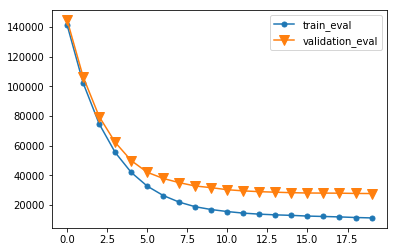

RMSE: [0]	eval-rmse:27784.953125
r-square for validation data is 0.8742842705878988
r-square for train data is 0.9796594456663883


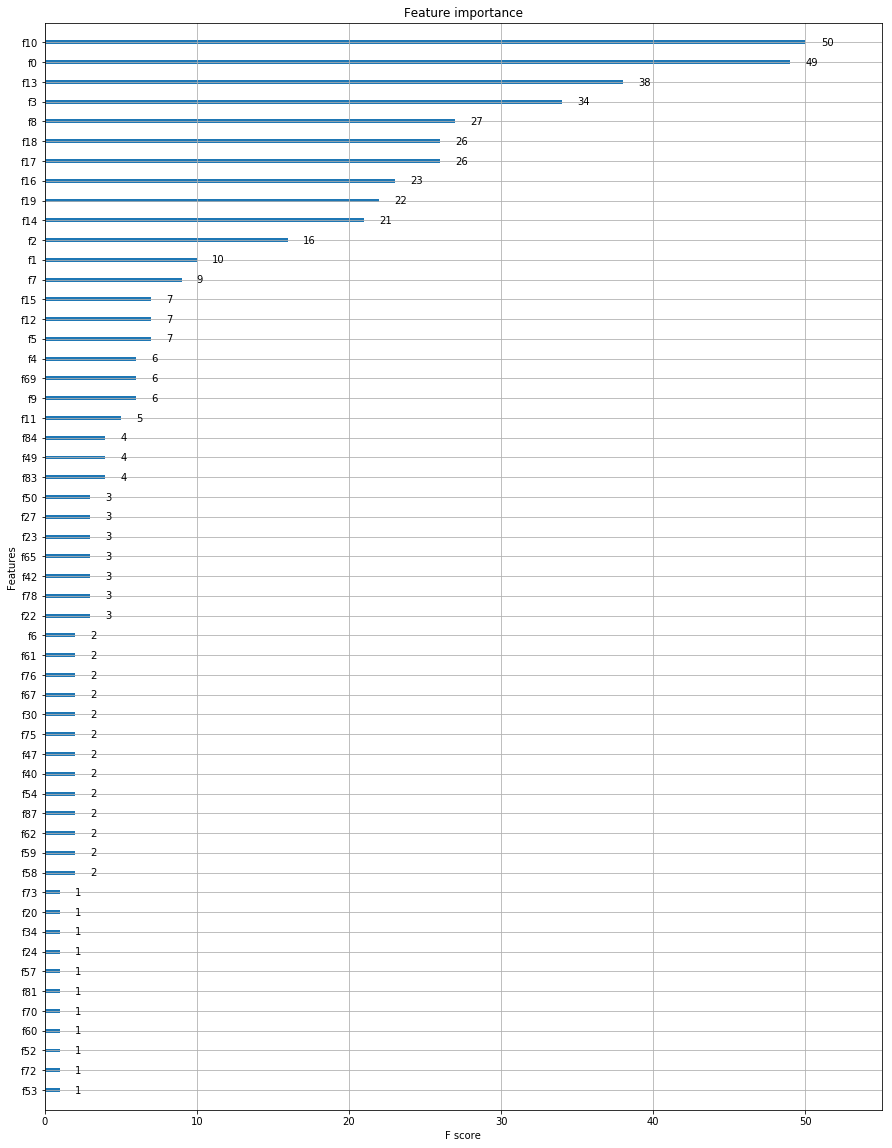

In [60]:
# 訓練模型
xgb_model = xgb_modeling(train_x, train_y, val_x, val_y)

#檢視各欄位重要性
fig, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(xgb_model, ax=ax)
plt.show()

In [61]:
test_x = xgb.DMatrix(test_x)
test_y = xgb_model.predict(test_x)

df_result = pd.DataFrame(df_test_org['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('submit/xgb_result.csv', index=False)